In [1]:
# AfriBERTa Training for Machine-Generated Text Detection
# Binary Classification: Human vs Machine-Generated Text in African Languages


# Install required packages
!pip install transformers datasets torch accelerate wandb scikit-learn pandas numpy matplotlib seaborn

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

from datasets import Dataset, DatasetDict
import wandb

from google.colab import drive
drive.mount('/content/drive')

import transformers
print(f"Transformers version: {transformers.__version__}")

!pip install numpy==1.26.4


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Transformers version: 4.48.3


In [2]:
# Configuration
class Config:
    # Model configuration
    MODEL_NAME = "castorini/afriberta_base"  # AfriBERTa base model
    MAX_LENGTH = 512
    NUM_LABELS = 2  # Binary classification (human vs machine)

    # Training configuration
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 5
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 2

    # Data configuration - based on your existing data structure
    TEXT_COLUMN = "clean_text"
    LABEL_COLUMN = "label"  # 0: human_text, 1: machine_generated
    LANGUAGE_COLUMN = "language"

    # Output configuration
    OUTPUT_DIR = "./afriberta_text_detection"
    LOGGING_DIR = "./logs"
    SAVE_STEPS = 500
    EVAL_STEPS = 500

    # Evaluation configuration
    EVAL_STRATEGY = "steps"
    SAVE_STRATEGY = "steps"
    LOAD_BEST_MODEL = True
    METRIC_FOR_BEST_MODEL = "eval_f1"

    # Set random seed for reproducibility
    SEED = 42

config = Config()

# Set random seeds for reproducibility
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")



Using device: cuda
GPU: Tesla T4


In [4]:
# Load cleaned dataset with lowercase machine starts
file_path = "/content/drive/My Drive/NLP/final_dataset2.csv"
df = pd.read_csv(file_path)

# Rename for consistency
df = df.rename(columns={"src_text": "clean_text"})

# Drop very short texts
df = df[df['clean_text'].str.split().str.len() > 5]

# Drop exact duplicates (to prevent leak from padding)
df = df.drop_duplicates(subset=["clean_text", "label", "language"])

# Sample balanced number of examples per label per language
balanced_parts = []
# Determine the minimum number of samples available across all language and label combinations
min_samples = df.groupby(["language", "label"]).size().min()
print(f"Minimum samples per language/label combination: {min_samples}")

for lang in df["language"].unique():
    for lbl in [0, 1]:
        subset = df[(df["language"] == lang) & (df["label"] == lbl)]
        # Sample min_samples from each subset
        if len(subset) > 0: # Ensure subset is not empty
            balanced_parts.append(subset.sample(n=min_samples, random_state=42))

df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)


# Create stratified split
df["stratify_col"] = df["language"] + "_" + df["label"].astype(str)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["stratify_col"]
)
train_df = train_df.drop(columns=["stratify_col"])
test_df = test_df.drop(columns=["stratify_col"])

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
print("Train label distribution:\n", train_df["label"].value_counts())
print("Test label distribution:\n", test_df["label"].value_counts())

Minimum samples per language/label combination: 451
Train size: (2886, 3), Test size: (722, 3)
Train label distribution:
 label
0    1443
1    1443
Name: count, dtype: int64
Test label distribution:
 label
0    361
1    361
Name: count, dtype: int64


=== Dataset Overview ===
Total samples: 3608
Unique languages: 4
Languages: ['nso' 'ven' 'xho' 'tso']


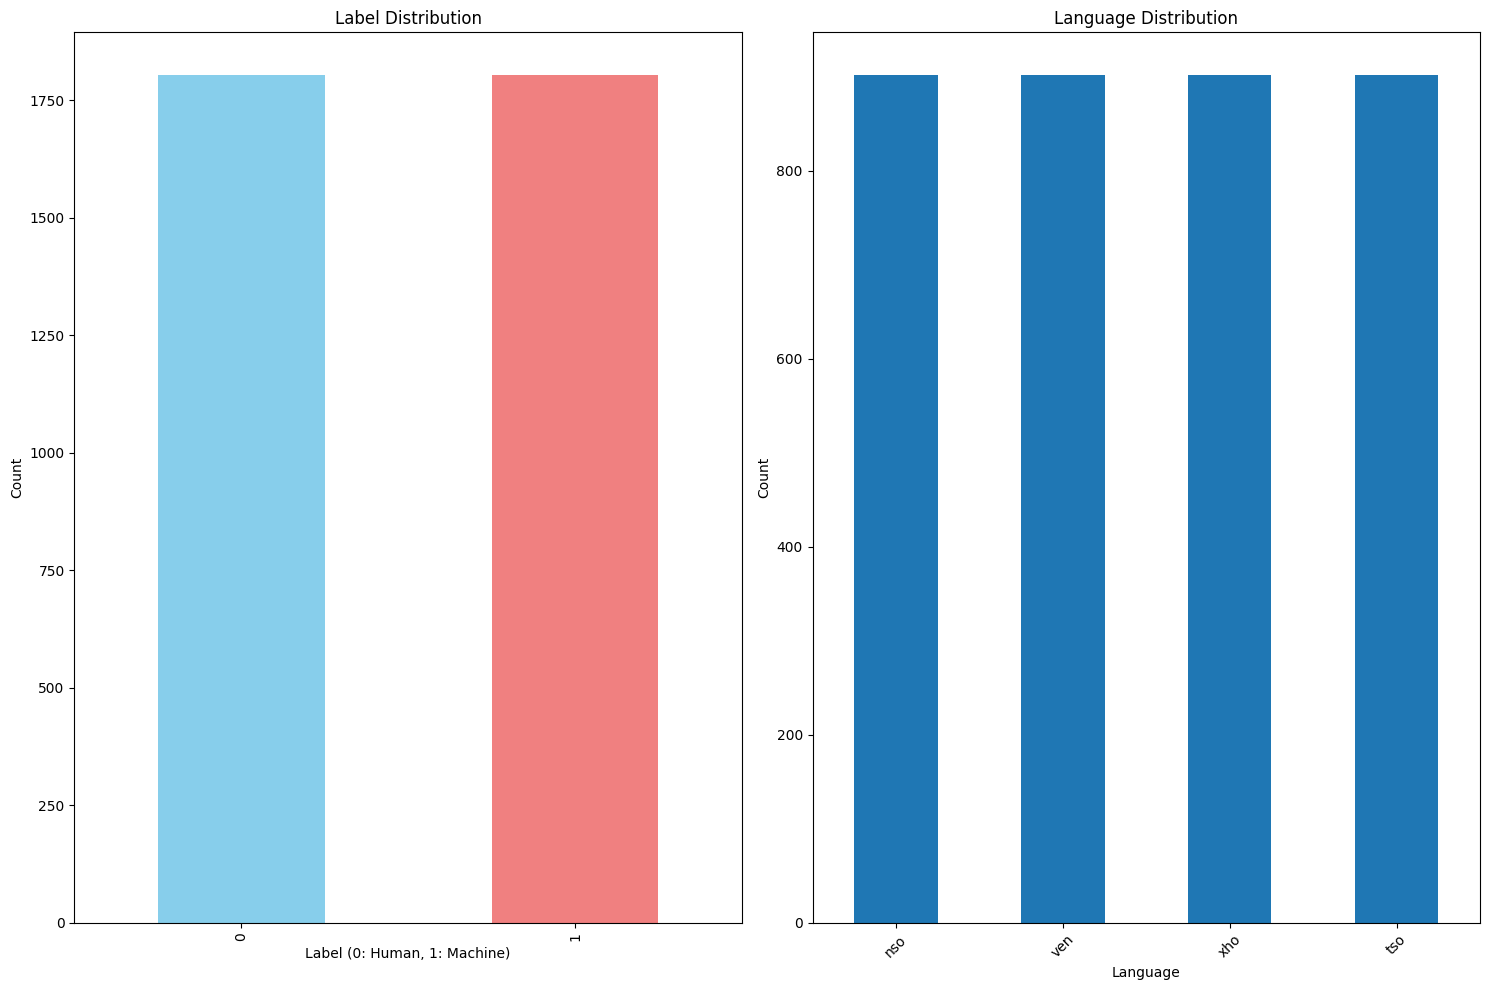

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [5]:
# Data preprocessing and exploration
def explore_data(df):
    """Explore the dataset characteristics"""
    print("=== Dataset Overview ===")
    print(f"Total samples: {len(df)}")
    print(f"Unique languages: {df['language'].nunique()}")
    print(f"Languages: {df['language'].unique()}")


    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # Label distribution
    df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
    axes[0].set_title('Label Distribution')
    axes[0].set_xlabel('Label (0: Human, 1: Machine)')
    axes[0].set_ylabel('Count')

    # Language distribution
    df['language'].value_counts().plot(kind='bar', ax=axes[1])
    axes[1].set_title('Language Distribution')
    axes[1].set_xlabel('Language')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df

# Explore your data
df = explore_data(df)

# Initialize tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    """Tokenize the text data"""
    return tokenizer(
        examples["clean_text"],  # Use 'clean_text' instead of config.TEXT_COLUMN
        truncation=True,
        padding=True,
        max_length=config.MAX_LENGTH,
        return_tensors="pt"
    )

In [6]:
from datasets import Dataset

# Keep only necessary columns before conversion to HuggingFace format
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[["clean_text", "label"]].reset_index(drop=True))

# Create a DatasetDict for easier handling
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_NAME, num_labels=config.NUM_LABELS)

# Move model to device
model.to(device)
print(f"Model loaded on device: {device}")

Map:   0%|          | 0/2886 [00:00<?, ? examples/s]

Map:   0%|          | 0/722 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda


In [7]:
# Define compute metrics function
def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'f1_human': f1_per_class[0],
        'f1_machine': f1_per_class[1],
        'precision_human': precision_per_class[0],
        'precision_machine': precision_per_class[1],
        'recall_human': recall_per_class[0],
        'recall_machine': recall_per_class[1]
    }

try:
    # Try newer version parameters first
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        warmup_steps=config.WARMUP_STEPS,
        weight_decay=config.WEIGHT_DECAY,
        logging_dir=config.LOGGING_DIR,
        logging_steps=100,
        eval_strategy="steps",  # newer versions
        eval_steps=config.EVAL_STEPS,
        save_strategy="steps",
        save_steps=config.SAVE_STEPS,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        save_total_limit=3,
        seed=config.SEED,
        learning_rate=config.LEARNING_RATE,
        report_to="none"
    )
except TypeError:

    # Fallback for older versions
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        warmup_steps=config.WARMUP_STEPS,
        weight_decay=config.WEIGHT_DECAY,
        logging_dir=config.LOGGING_DIR,
        logging_steps=100,
        evaluation_strategy="steps",  # older versions
        eval_steps=config.EVAL_STEPS,
        save_steps=config.SAVE_STEPS,
        load_best_model_at_end=True,
        seed=config.SEED,
        learning_rate=config.LEARNING_RATE,
        report_to="none"
    )

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],  # Changed from val_dataset to test_dataset
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


print("Starting training...")
# Train the model
trainer.train()

# Save the final model
trainer.save_model(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

print("Training completed! Model saved to:", config.OUTPUT_DIR)

# Evaluate on test set
print("\n=== Evaluating on Test Set ===")
test_results = trainer.evaluate(tokenized_datasets["test"])
print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

Starting training...


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Human,F1 Machine,Precision Human,Precision Machine,Recall Human,Recall Machine
500,0.023100,0.000332,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


KeyboardInterrupt: 

In [ ]:

from datasets import Dataset

# Keep only necessary columns before conversion to HuggingFace format
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[["clean_text", "label"]].reset_index(drop=True))


In [ ]:
print("\n=== Training and Evaluation Complete! ===")
print(f"Final model saved to: {config.OUTPUT_DIR}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get predictions from the trainer
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_test = predictions.label_ids

# Get the language column from the test_df
# Assuming test_df is available and has a 'language' column
lang_column = test_df['language'].reset_index(drop=True)

# Create a DataFrame with results
df_results = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_pred,
    'language': lang_column
})

languages = df_results['language'].unique()

for lang in languages:
    subset = df_results[df_results['language'] == lang]
    cm = confusion_matrix(subset['true_label'], subset['predicted_label'], labels=np.unique(y_test))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {lang}")
    plt.xticks(rotation=45)
    plt.show()